# Model Fitting: Confidence intervals and bootstrapping
# Tutorial Objectives
We discuss the bias-variance trade-off (Tutorial 5) and Cross Validation for model selection (Tutorial 6).


Learn how to use bootstrapping to generate new sample datasets
Estimate our model parameter on these new sample datasets
Quantify the variance of our estimate using confidence intervals

Up to this point we have been finding ways to estimate model parameters to fit some observed data. Our approach has been to optimize some criterion, either minimize the mean squared error or maximize the likelihood while using the entire dataset. How good is our estimate really? How confident are we that it will generalize to describe new data we haven't seen yet?

One solution to this is to just collect more data and check the MSE on this new dataset with the previously estimated parameters. However this is not always feasible and still leaves open the question of how quantifiably confident we are in the accuracy of our model.

In Section 1, we will explore how to implement bootstrapping. In Section 2, we will build confidence intervals of our estimates using the bootstrapping method.
## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [12]:

def solve_normal_eqn(x, y):

  theta_hat = (x.T @ y) / (x.T @ x)
  return theta_hat

## Section 1: Bootstrapping
Bootstrapping is a widely applicable method to assess confidence/uncertainty about estimated parameters, it was originally proposed by Bradley Efron. The idea is to generate many new synthetic datasets from the initial true dataset by randomly sampling from it, then finding estimators for each one of these new datasets, and finally looking at the distribution of all these estimators to quantify our confidence.

Note that each new resampled datasets will be the same size as our original one, with the new data points sampled with replacement i.e. we can repeat the same data point multiple times. Also note that in practice we need a lot of resampled datasets, here we use 2000.

To explore this idea, we will start again with our noisy samples along the line $y_n = 1.2x_n + \epsilon_n$, but this time only use half the data points as last time (15 instead of 30).

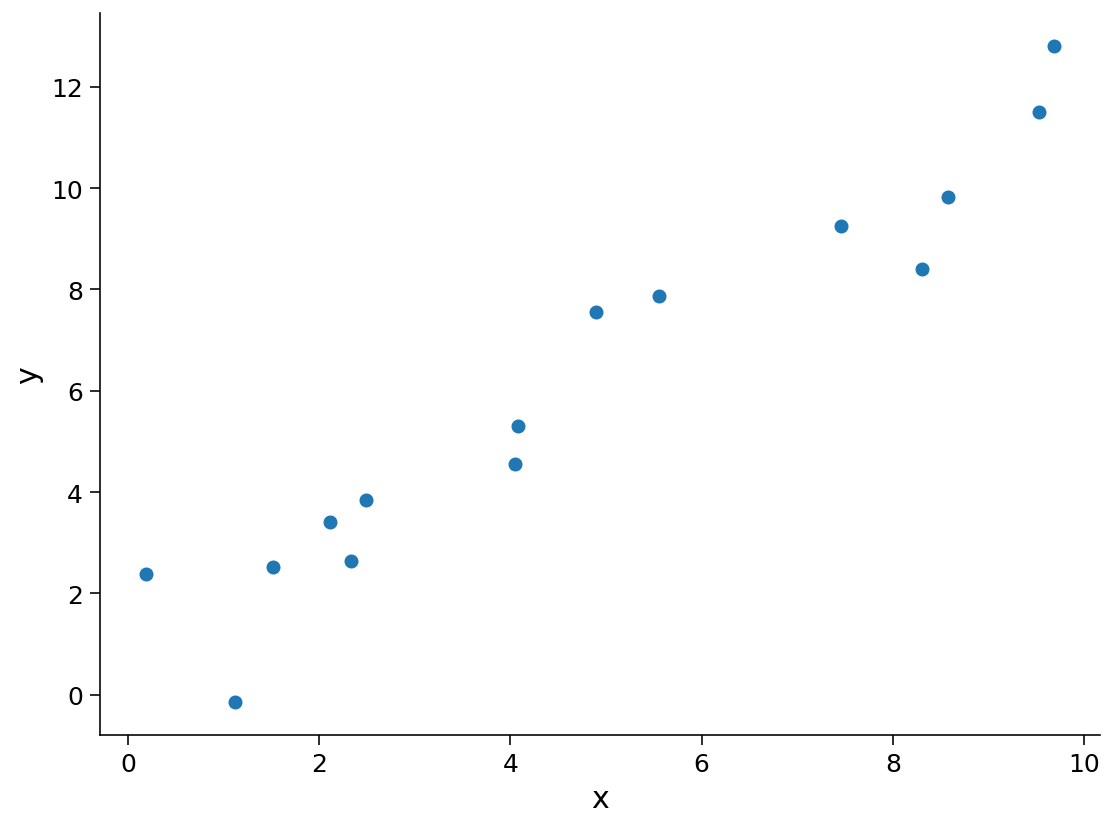

In [14]:

np.random.seed(121)

theta = 1.2
n_samples = 15

x = 10 * np.random.rand(n_samples)  
noise = np.random.randn(n_samples)  
y = theta * x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set(xlabel='x', ylabel='y');

### Exercise 1: Resample Dataset with Replacement
In this exercise you will implement a method to resample a dataset with replacement. The method accepts $x$ and $y$ arrays. It should return a new set of $x'$ and $y'$ arrays that are created by randomly sampling from the originals.

We will then compare the original dataset to a resampled dataset.

TIP: The numpy.random.choice method would be useful here.

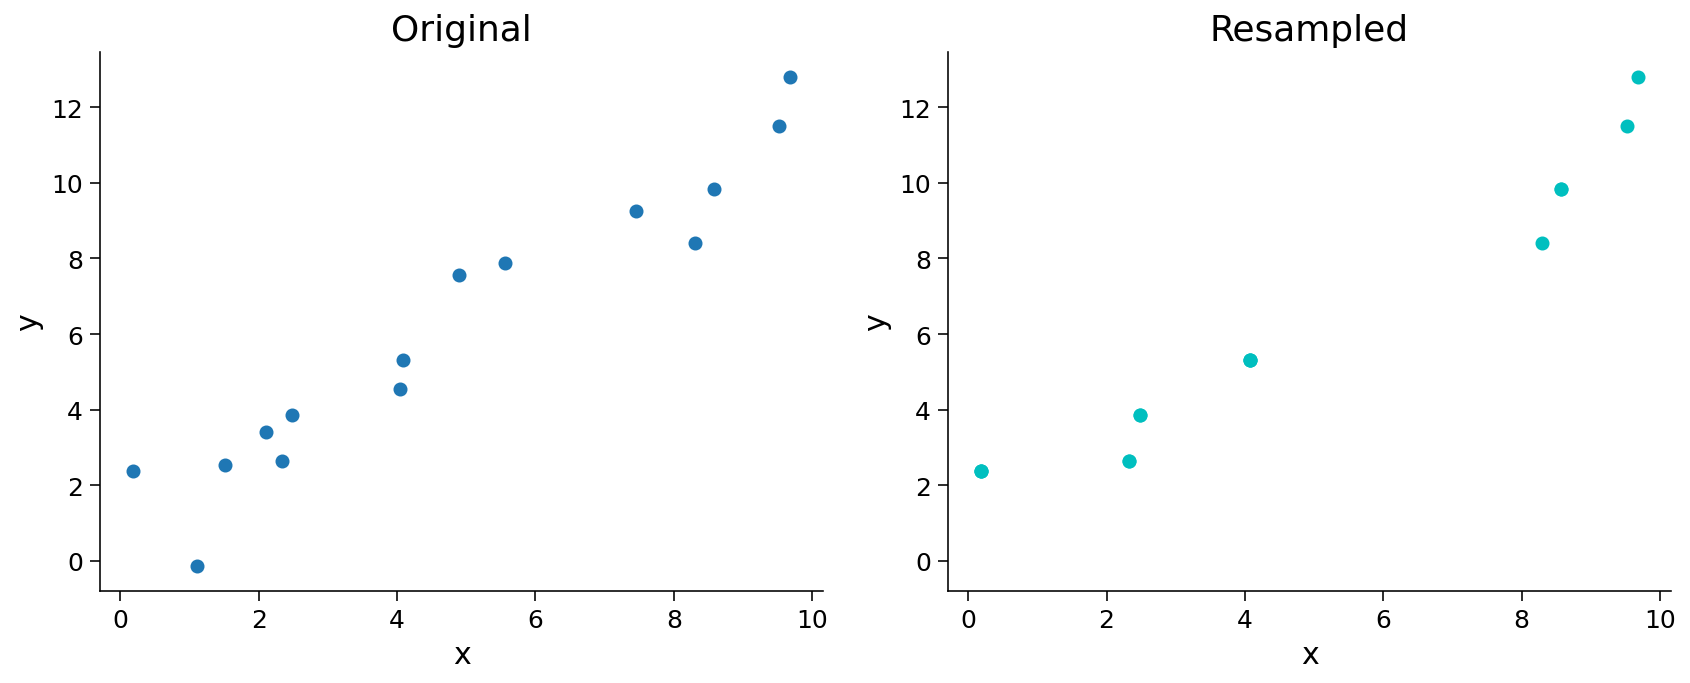

In [30]:
def resample_with_replacement(x, y):
  sample_idx = np.random.choice(len(x), size = len(x), replace=True)
  x_ = x[sample_idx]
  y_ = y[sample_idx]
  return x_, y_


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.scatter(x, y)
ax1.set(title='Original', xlabel='x', ylabel='y')

x_, y_ = resample_with_replacement(x, y)
ax2.scatter(x_, y_, color='c')

ax2.set(title='Resampled', xlabel='x', ylabel='y',
        xlim=ax1.get_xlim(), ylim=ax1.get_ylim());

Example output:

In the resampled plot on the right, the actual number of points is the same, but some have been repeated so they only display once.

Now that we have a way to resample the data, we can use that in the full bootstrapping process.

### Exercise 2: Bootstrap Estimates
In this exercise you will implement a method to run the bootstrap process of generating a set of $\hat\theta$ values from a dataset of $x$ inputs and $y$ measurements. You should use resample_with_replacement here, and you may also invoke helper function solve_normal_eqn from Tutorial 1 to produce the MSE-based estimator.

We will then use this function to look at the theta_hat from different samples.

In [31]:
def bootstrap_estimates(x, y, n=2000):
  
  theta_hats = np.zeros(n)

  for i in range(n):

    x_, y_ = resample_with_replacement(x, y)

    theta_hats[i] = solve_normal_eqn(x_,y_)

  return theta_hats


np.random.seed(123)

theta_hats = bootstrap_estimates(x, y, n=2000)
print(theta_hats[0:5])


[1.27550888 1.17317819 1.18198819 1.25329255 1.20714664]


You should see [1.27550888 1.17317819 1.18198819 1.25329255 1.20714664] as the first five estimates.

Now that we have our bootstrap estimates, we can visualize all the potential models (models computed with different resampling) together to see how distributed they are.

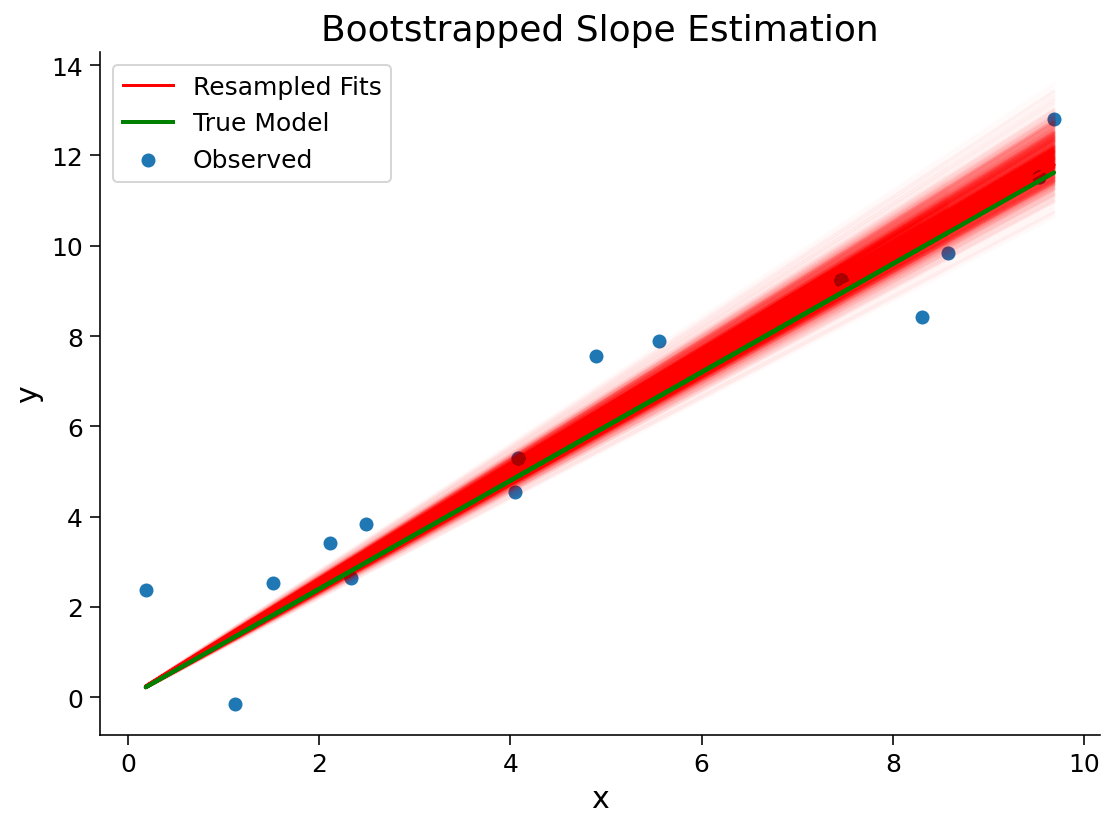

In [32]:


fig, ax = plt.subplots()

theta_hats = bootstrap_estimates(x, y, n=2000)

for i, theta_hat in enumerate(theta_hats):
  y_hat = theta_hat * x
  ax.plot(x, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i==0 else '')

ax.scatter(x, y, label='Observed')

y_true = theta * x
ax.plot(x, y_true, 'g', linewidth=2, label='True Model')

ax.set(
  title='Bootstrapped Slope Estimation',
  xlabel='x',
  ylabel='y'
)

handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)

ax.legend();

This looks pretty good! The bootstrapped estimates spread around the true model, as we would have hoped. Note that here we have the luxury to know the ground truth value for $\theta$, but in applications we are trying to guess it from data. Therefore, assessing the quality of estimates based on finite data is a task of fundamental importance in data analysis.

## Section 2: Confidence Intervals
Let us now quantify how uncertain our estimated slope is. We do so by computing confidence intervals (CIs) from our bootstrapped estimates. The most direct approach is to compute percentiles from the empirical distribution of bootstrapped estimates. Note that this is widely applicable as we are not assuming that this empirical distribution is Gaussian.

mean = 1.24, std = 0.05


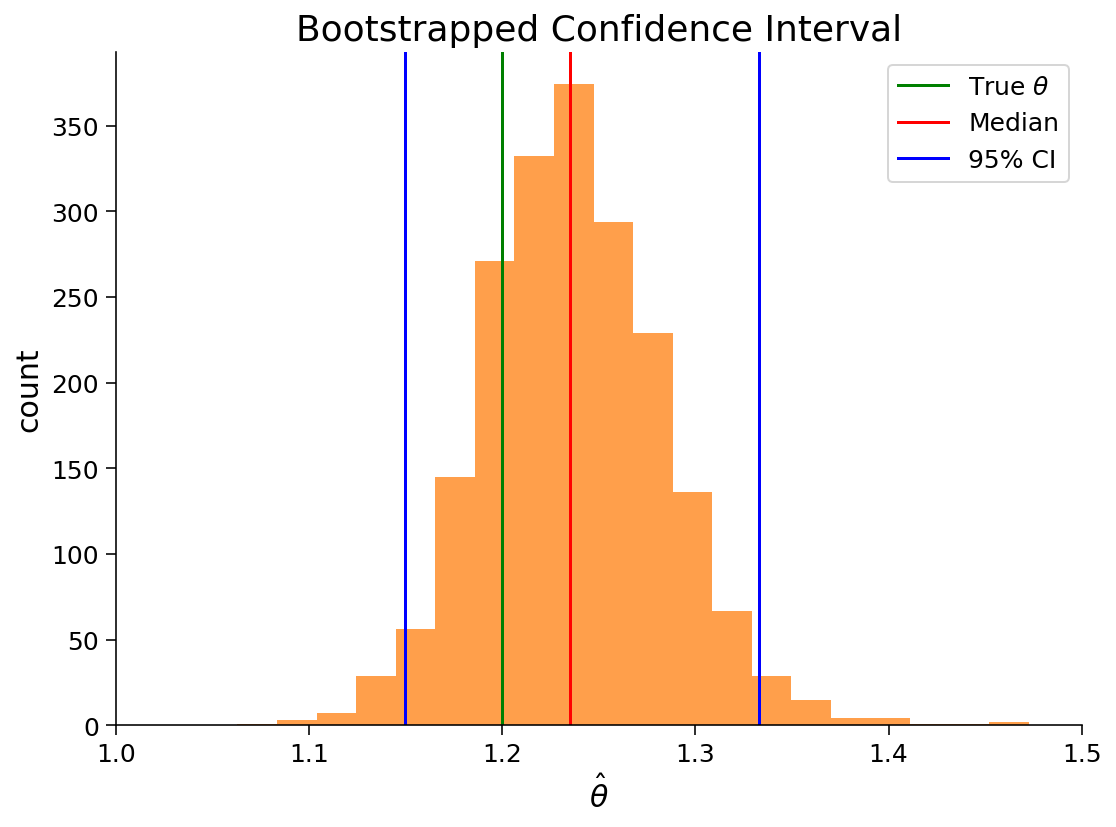

In [33]:

theta_hats = bootstrap_estimates(x, y, n=2000)
print(f"mean = {np.mean(theta_hats):.2f}, std = {np.std(theta_hats):.2f}")

fig, ax = plt.subplots()
ax.hist(theta_hats, bins=20, facecolor='C1', alpha=0.75)
ax.axvline(theta, c='g', label=r'True $\theta$')
ax.axvline(np.percentile(theta_hats, 50), color='r', label='Median')
ax.axvline(np.percentile(theta_hats, 2.5), color='b', label='95% CI')
ax.axvline(np.percentile(theta_hats, 97.5), color='b')
ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel=r'$\hat{{\theta}}$',
    ylabel='count',
    xlim=[1.0, 1.5]
);